<a href="https://colab.research.google.com/github/FredJones4/671_controlbook_D/blob/master/pytorch_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [18]:

import torch, torchvision
# print(f"PyTorch: {torch.__version__}, CUDA: {torch.version.cuda}")
# print(f"Torchvision: {torchvision.__version__}, CUDA: {torchvision._C._cuda_compiled_version()}")


In [19]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [20]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

In [21]:
# Taking a moment to understand what ToTensor() looks like

from PIL import Image
from torchvision.transforms import ToTensor

# Open an image using PIL
pil_image = Image.open("example.jpg")  # Load a sample image

# Apply ToTensor() transformation
tensor_image = ToTensor()(pil_image)

print(type(tensor_image))  # Output: <class 'torch.Tensor'>
print(tensor_image.shape)  # Output: (C, H, W)  [Channels, Height, Width]
print(tensor_image.min(), tensor_image.max())  # Output: tensor(0.) tensor(1.)


<class 'torch.Tensor'>
torch.Size([3, 300, 300])
tensor(0.) tensor(1.)


In [22]:
import numpy as np
from torchvision.transforms import ToTensor

# Create a fake image as a NumPy array (H, W, C) with random values
numpy_image = np.random.randint(0, 256, (128, 128, 3), dtype=np.uint8)

# Convert NumPy array to PyTorch tensor
tensor_image = ToTensor()(numpy_image)

print(type(tensor_image))  # Output: <class 'torch.Tensor'>
print(tensor_image.shape)  # Output: (C, H, W)
print(tensor_image.min(), tensor_image.max())  # Output: tensor(0.) tensor(1.)


<class 'torch.Tensor'>
torch.Size([3, 128, 128])
tensor(0.) tensor(1.)


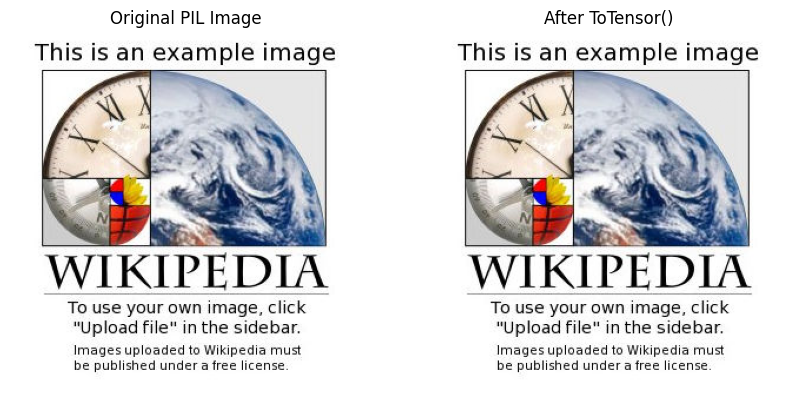

In [23]:
import matplotlib.pyplot as plt

# Load PIL image
pil_image = Image.open("example.jpg")

# Convert using ToTensor
tensor_image = ToTensor()(pil_image)

# Convert back to NumPy for visualization
numpy_image = tensor_image.permute(1, 2, 0).numpy()  # Convert (C, H, W) to (H, W, C)

# Plot images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(pil_image)
ax[0].set_title("Original PIL Image")
ax[0].axis("off")

ax[1].imshow(numpy_image)
ax[1].set_title("After ToTensor()")
ax[1].axis("off")

plt.show()


In [24]:
# Back to tutorial

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [25]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


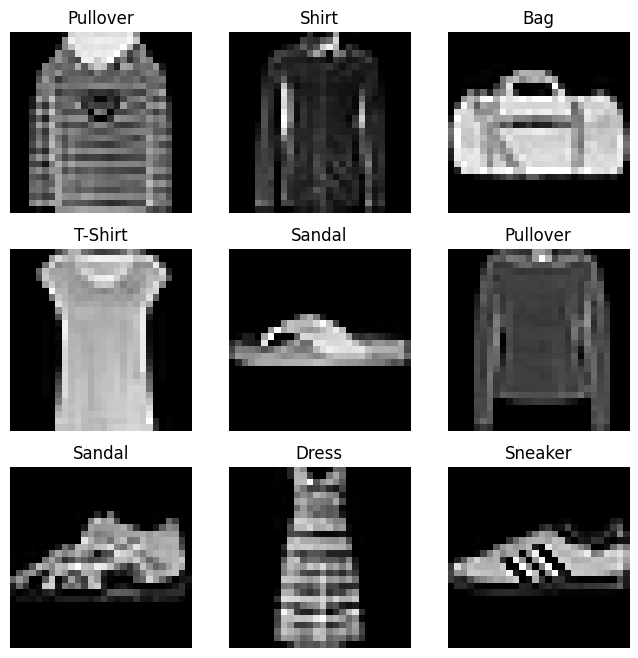

In [26]:
#visualizing some samples


labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
# import torch_xla
# import torch_xla.core.xla_model as xm

# print(f"PyTorch XLA Version: {torch_xla.__version__}")
# print(f"TPU Device: {xm.xla_device()}")


In [27]:

import torch

# Check available accelerator
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

print(f"Using device: {device}")


AttributeError: module 'torch' has no attribute 'accelerator'

In [28]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
# device = xm.xla_device()  # Get the TPU device
# print(f"Using device: {device}")


# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

AttributeError: module 'torch' has no attribute 'accelerator'

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.297584  [   64/60000]
loss: 2.292873  [ 6464/60000]


KeyboardInterrupt: 